# Objective:

The objective of this assignment is to find

* Which variables are significant in predicting the demand for shared bikes.
* How well those variables describe the bike demands

The assignment is divided into the 
1. EDA
2. Preparing the data for building the model
3. Feature selction using RFE
4. Modeling
5. Residual analysis
6. Predictions of the test data

## 1. EDA

In [1]:
# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the needed modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
#Reading the data
bike_data = pd.read_csv("day.csv")

In [4]:
# Checking the columns
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
#Checking the shape of the dataset
bike_data.shape

(730, 16)

In [6]:
#Checking the datatypes and null Values
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Columns doesn't have any null values and all the datatypes are also proper. Season, weekday, mnth and the weathersit are categorical values and we will be replacing the values of these columns with the actual variable names.

In [7]:
#Replacing the season categorical variable values with the actual season names
bike_data['season'] = bike_data['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [8]:
bike_data[422:427]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
422,423,27-02-2019,spring,1,2,0,1,1,1,15.033347,17.89770,49.0833,17.958211,253,4069,4322
423,424,28-02-2019,spring,1,2,0,2,1,1,14.725847,17.67625,39.5833,12.958939,229,4134,4363
424,425,01-03-2019,spring,1,3,0,4,1,1,19.919153,23.76855,61.5417,15.208129,325,4665,4990
425,426,02-03-2019,spring,1,3,0,5,1,2,14.486653,17.99210,65.7083,9.708568,246,2948,3194
426,427,03-03-2019,spring,1,3,0,6,0,2,16.980847,20.67460,62.1250,10.792293,956,3110,4066


If we observe the above data, in the 424th row, the weekday has to be 3 but it might have mistakenly updated as 4 and all the subsequent weekday values are also wrong. The working day column is also derived from this weekday column. If I want to update it, i should modify multiple columns, so I prefer not to modify any data and proceed with the dataset provided.

In [9]:
#Replacing the weekday categorical variable values with the actual weekday names
bike_data['weekday'] = bike_data['weekday'].map({0:'Tue', 1:'Wed', 2:'Thu', 3:'Fri', 4:'Sat', 5:'Sun', 6:'Mon'})

In [10]:
#Replacing the month categorical variable values with the actual month names
bike_data['mnth'] = bike_data['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                                                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})

In [11]:
#Replacing the weathersit categorical variable values with the actual weathersit names
bike_data['weathersit'] = bike_data['weathersit'].map({1:'clear', 2:'cloudy', 3:'light_rain', 4:'heavy_rain'})

In [12]:
'''Dropping the unwanted columns:
instant: It's just a index of the record and doesn't need to do anything with the target variable.
dteday: We have derived enough variables from the date, hence dropping this one
casual, registered: These are subgroups of the cnt. We are interested in the total number of the bike rentals. So dropping these
two as well.
'''
bike_data = bike_data.drop(['instant','dteday','casual','registered'],axis=1)

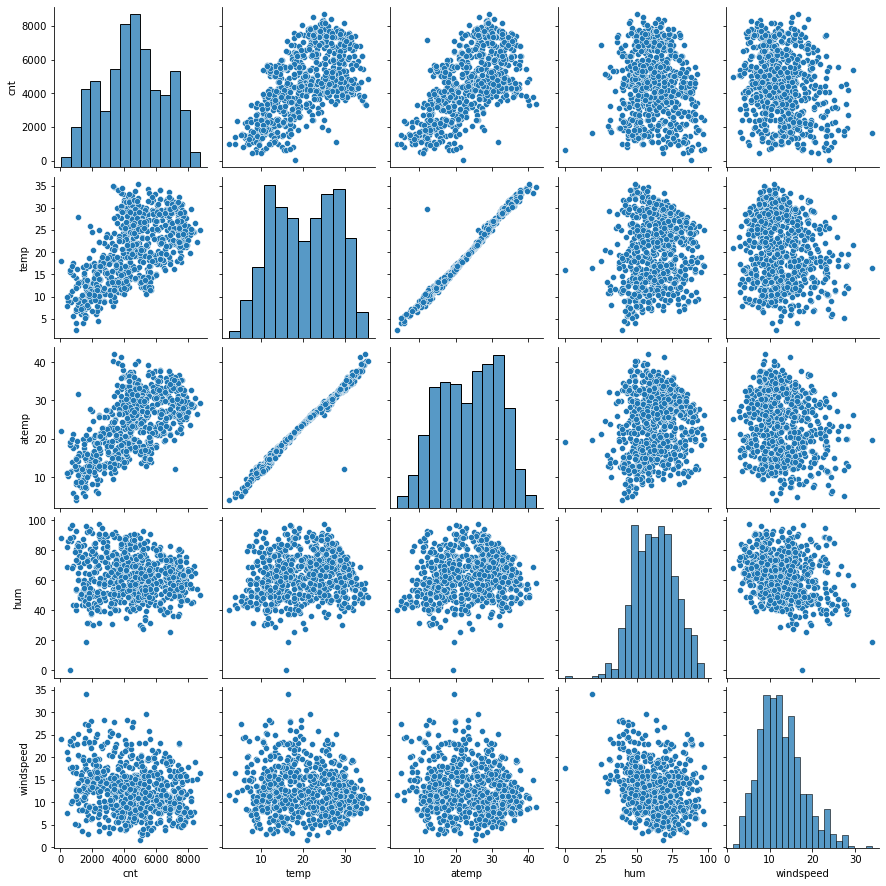

In [13]:
#Pair-plot againest the available numeric variables
sns.pairplot(bike_data[['cnt','temp','atemp','hum','windspeed']])

From the above plot, it is clear that the cnt is showing high correlation with the atemp and temp(which is highly correlated with the atemp)

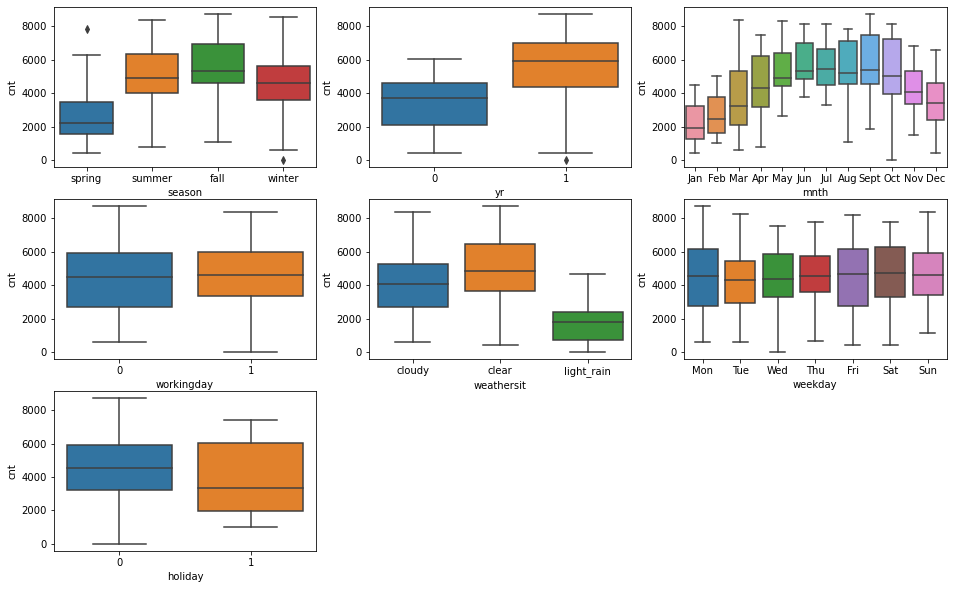

In [14]:
#Plotting the box plot for the categorical variable
plt.figure(figsize=(16,10))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_data)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike_data)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_data)
plt.subplot(3,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_data)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_data)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_data)
plt.subplot(3,3,7)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_data)
plt.show()

* Season: The bike rentals are more in the fall season followed by the summer and the winter. Bike rentals are very less in the spring season
* Year: The bike rentals are increased in the second year (2019) compared to the first year (2018).
* Month: The bike rentals are less during the January and gradually increasing till Jun-July then gradually decreasing till December. Overall, the bike rentals are high during the May-Sept Period.
* Weathersit: Bike rentals are more when the weather situation is clear and less when there is a light rain.
* Bike rentals are not varying much across the weekdays also it is not varying much whether it is a holiday or working day.

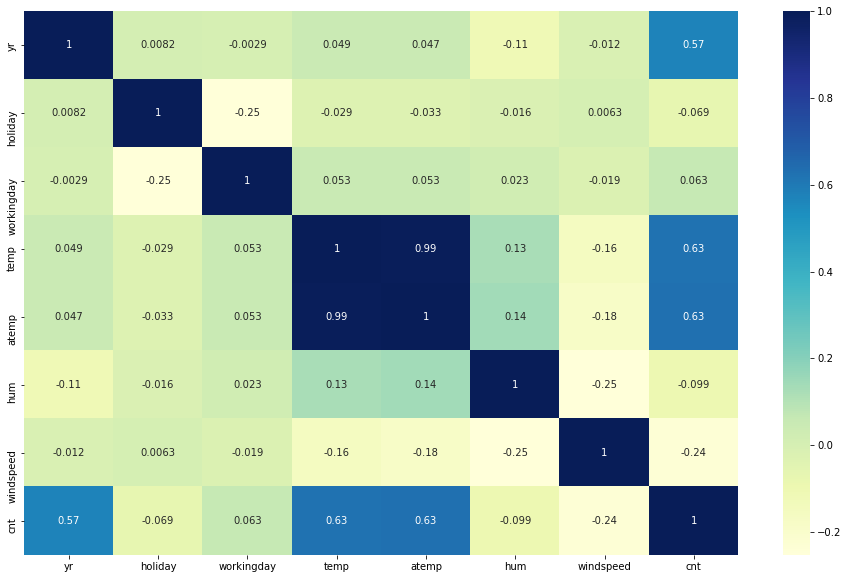

In [15]:
plt.figure(figsize = (16, 10))
sns.heatmap(bike_data.corr(), annot = True, cmap="YlGnBu")
plt.show()

From the above heatmap, it is cleared that the temp and atemp are highly correlated. Since the atemp is the feeling temprature, We are proceeding with the atemp variable and dropping the temp variable.

In [16]:
bike_data = bike_data.drop(['temp'],axis=1)

## 2. Preparing the data for building the model

In [17]:
'''Function to create the dummy variables. It creates the dummy variable, drops the first dummy variable, 
concatenates this with the original dataset and removes the original categorical column'''
def create_dummy(dataframe, column_name):
    temp_df = pd.get_dummies(dataframe[column_name], drop_first = True)
    dataframe = pd.concat([dataframe, temp_df], axis = 1)
    dataframe.drop([column_name], axis = 1, inplace = True)
    return dataframe

In [18]:
# Categorical columns for which we need to create the dummy variables
cate_columns = ['season','mnth','weekday','weathersit']
# Creates the dummy variables
for column in cate_columns:
    bike_data = create_dummy(bike_data, column)
bike_data.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sept,Mon,Sat,Sun,Thu,Tue,Wed,cloudy,light_rain
0,0,0,0,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Splitting the data into the train and test data set
np.random.seed(0)
bike_data_train, bike_data_test = train_test_split(bike_data, train_size = 0.7, test_size = 0.3, random_state = 100)

In [20]:
# Scaling the numeric columns
scaler = MinMaxScaler()
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
bike_data_train[num_vars] = scaler.fit_transform(bike_data_train[num_vars])

In [21]:
bike_data_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sept,Mon,Sat,Sun,Thu,Tue,Wed,cloudy,light_rain
653,1,0,1,0.501133,0.575354,0.300794,0.864243,0,0,1,...,1,0,0,0,0,1,0,0,0,0
576,1,0,1,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,0,0,0,0,1,0
728,1,0,0,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,0,0,0,0,1,0


In [22]:
# Creating the y_train with the target varaible, cnt.
y_train = bike_data_train.pop('cnt')
X_train = bike_data_train

## 3. Feature selection using RFE

In [23]:
#Buildinng the RFE and selecting the top-15 variables from the RFE
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

In [24]:
#Seeing the RFE Results
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 2),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 5),
 ('winter', True, 1),
 ('Aug', False, 6),
 ('Dec', True, 1),
 ('Feb', False, 3),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 7),
 ('Mar', False, 14),
 ('May', False, 4),
 ('Nov', True, 1),
 ('Oct', False, 12),
 ('Sept', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 13),
 ('Sun', False, 11),
 ('Thu', False, 10),
 ('Tue', False, 8),
 ('Wed', False, 9),
 ('cloudy', True, 1),
 ('light_rain', True, 1)]

In [25]:
# Taking top 15 independent variables from the RFE
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'spring', 'winter', 'Dec',
       'Jan', 'Jul', 'Nov', 'Sept', 'Mon', 'cloudy', 'light_rain'],
      dtype='object')

In [26]:
# Taking top 15 independent variables from the RFE
X_train_rfe = X_train[col]

## 4. Modeling

In [27]:
# Adding the constant to the dataset
X_train_rfe = sm.add_constant(X_train_rfe)

In [28]:
#Building the model
lm = sm.OLS(y_train,X_train_rfe).fit() 

In [29]:
#Checking the summary of model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     175.4
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          9.67e-187
Time:                        16:17:20   Log-Likelihood:                 508.84
No. Observations:                 510   AIC:                            -985.7
Df Residuals:                     494   BIC:                            -917.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3662      0.032     11.425      0.0

We have very close R-squared and the adjusted R-Squared values which tells that we haven't used more independent varaibles for the anlysis.

The probability value of the Mon column is more than 0.1 whereas the general significance level is 0.05. So we are failed to reject the null hypothesis that the beta value corresponding to the Mon column is 0 which is nothing but the Mon column is not showing the significance on the target variable. Before dropping this we can look into the VIF Values as well.

In [30]:
# Calculating the VIF Values
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,63.75
3,atemp,3.39
6,spring,2.69
7,winter,2.30
4,hum,1.92
11,Nov,1.70
9,Jan,1.65
14,cloudy,1.57
8,Dec,1.45
10,Jul,1.30


All the columns has the VIF value less than 5, which is nothing but the independent variables are not heavily correlated with the other independent variables.

In [31]:
# Dropping the Mon variable as the p-value is more than the 0.05
X_train_rfe = X_train_rfe.drop('Mon', 1)

In [32]:
#Building the model and checking the summaries
lm = sm.OLS(y_train,X_train_rfe).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     187.1
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          2.58e-187
Time:                        16:17:20   Log-Likelihood:                 507.48
No. Observations:                 510   AIC:                            -985.0
Df Residuals:                     495   BIC:                            -921.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3704      0.032     11.578      0.0

Now, we got the model, where all the p-values are less than the 0.05 and the R-squared is very close with the adjusted R-squares. And the VIF will decrease or not change when we drop the variable but it won't increase. So we can freeze the model here. 

And proceed with the Residual analysis.

## 5. Residual Analysis

In [33]:
# Predicting the y variable with the model and calculating the residuals
y_train_cnt = lm.predict(X_train_rfe)
res = (y_train - y_train_cnt)

Text(0.5, 0, 'Errors')

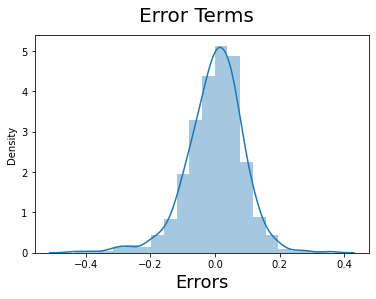

In [34]:
# Plotting the residuals 
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

From the above plot, it is clear that the error terms are centered around 0 (mean is 0) and following the normal distribution.

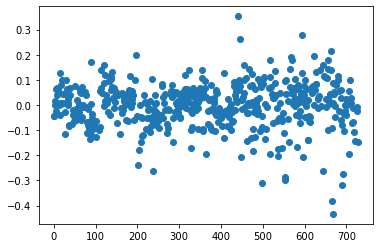

In [35]:
# Plotting the residuals against the row number
plt.scatter(res.index,res)
plt.show()

## Predictions of the test data

Performing the same opertions on the test data that we have done on the train data.
* Doing the scaling
* Taking the cnt as the target variable
* Removing the columns from the RFE Analysis
* Adding the constants.
* Dropping the variables from the model analysis

In [36]:
# Scaling the continuous variables
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
bike_data_test[num_vars] = scaler.transform(bike_data_test[num_vars])

In [37]:
# Taking the cnt as the target variable
y_test = bike_data_test.pop('cnt')
X_test = bike_data_test

In [38]:
# Removing the columns from the RFE Analysis
X_test = X_test[col]

In [39]:
# Adding the constants.
X_test = sm.add_constant(X_test)

In [40]:
# Dropping the Mon Varible
X_test = X_test.drop("Mon", axis = 1)

In [41]:
# Predicting on the test data
y_pred = lm.predict(X_test)

In [42]:
# R^2 of the test data
r_squared = r2_score(y_test, y_pred)
r_squared

0.8280997497313299

The R^2 of the test data is very close to the train data's R^2. So our model is working fine

The top-3 variables impacting bike retanls are 
1.	atemp
2.	light_rain
3.	yr